In [11]:
import pandas as pd
# from sklearn.model_selection import train_test_split # 不再需要随机划分
import lightgbm as lgb
from tqdm.notebook import tqdm  # 如果在notebook环境
# from tqdm import tqdm # 如果在普通python脚本环境
import gc  # 垃圾回收
import warnings
warnings.filterwarnings('ignore', category=UserWarning)  # 忽略一些 pandas 的警告

# --- 1. 数据加载与预处理 ---
print("Loading data...")
dtype_spec = {
    'UserID': 'category',
    'UserBehaviour': 'int8',
    'BloggerID': 'category',
    'Time': 'str'
}
df_hist = pd.read_csv('/Users/pp/projects/51MCM2025/program/a1.csv', dtype=dtype_spec)
df_future_interactions = pd.read_csv('/Users/pp/projects/51MCM2025/program/a2.csv', dtype=dtype_spec)


Loading data...


In [12]:

print("Preprocessing data...")
df_hist['Time'] = pd.to_datetime(df_hist['Time'])
df_future_interactions['Time'] = pd.to_datetime(df_future_interactions['Time'])
df_hist['Date'] = pd.to_datetime(df_hist['Time'].dt.date)
df_future_interactions['Date'] = pd.to_datetime(
    df_future_interactions['Time'].dt.date)

# --- 时间点定义 ---
# 用于训练集构建
train_hist_end_date = pd.to_datetime('2024-07-18')  # 训练集历史特征截止日期
train_label_date = pd.to_datetime('2024-07-19')    # 训练集标签 & 当天互动特征日期

# 用于验证集构建
val_hist_end_date = pd.to_datetime('2024-07-19')    # 验证集历史特征截止日期
val_label_date = pd.to_datetime('2024-07-20')       # 验证集标签 & 当天互动特征日期

# 用于最终预测
predict_hist_end_date = pd.to_datetime('2024-07-20')  # 预测时历史特征截止日期
predict_interaction_date = pd.to_datetime('2024-07-22')  # 预测目标的当天互动日期

print(
    f"Train history ends: {train_hist_end_date.date()}, Train label date: {train_label_date.date()}")
print(
    f"Validation history ends: {val_hist_end_date.date()}, Validation label date: {val_label_date.date()}")
print(
    f"Prediction history ends: {predict_hist_end_date.date()}, Prediction interaction date: {predict_interaction_date.date()}")


# 预处理 UserID 和 BloggerID 为 category 类型 (如果加载时未指定或需要统一)
# all_users = pd.concat([df_hist['UserID'], df_future_interactions['UserID']]).astype(str).unique()
# all_bloggers = pd.concat([df_hist['BloggerID'], df_future_interactions['BloggerID']]).astype(str).unique()
# df_hist['UserID'] = df_hist['UserID'].astype('category') # .cat.set_categories(all_users)
# df_hist['BloggerID'] = df_hist['BloggerID'].astype('category') # .cat.set_categories(all_bloggers)
# df_future_interactions['UserID'] = df_future_interactions['UserID'].astype('category') #.cat.set_categories(all_users)
# df_future_interactions['BloggerID'] = df_future_interactions['BloggerID'].astype('category') #.cat.set_categories(all_bloggers)

print("Data loaded and preprocessed.")
gc.collect()


Preprocessing data...
Train history ends: 2024-07-18, Train label date: 2024-07-19
Validation history ends: 2024-07-19, Validation label date: 2024-07-20
Prediction history ends: 2024-07-20, Prediction interaction date: 2024-07-22
Data loaded and preprocessed.


27

In [13]:

# --- 辅助函数：构建标签数据 ---


def build_label_data(df_hist, label_date, hist_end_date):
    """为指定日期构建正负样本"""
    print(
        f"Building label data for date: {label_date.date()} based on history up to {hist_end_date.date()}...")

    # 标签日期的互动数据
    label_day_interactions = df_hist[df_hist['Date'] == label_date].copy()
    if label_day_interactions.empty:
        print(
            f"Warning: No interactions found for label date {label_date.date()}")
        return pd.DataFrame(columns=['UserID', 'BloggerID', 'label']), label_day_interactions

    # 找出在标签日期 *之前* 已经关注的对
    hist_follows = df_hist[(df_hist['Date'] <= hist_end_date) & (
        df_hist['UserBehaviour'] == 4)][['UserID', 'BloggerID']].drop_duplicates()
    hist_follows['already_followed'] = 1

    # 正样本：标签日期发生的新关注
    positive_samples = label_day_interactions[label_day_interactions['UserBehaviour'] == 4][[
        'UserID', 'BloggerID']].drop_duplicates()
    positive_samples = pd.merge(positive_samples, hist_follows, on=[
                                'UserID', 'BloggerID'], how='left')
    # 确保是新关注
    positive_samples = positive_samples[positive_samples['already_followed'].isna(
    )]
    positive_samples = positive_samples[['UserID', 'BloggerID']]
    positive_samples['label'] = 1

    # 负样本候选：标签日期有互动(1,2,3)的用户-博主对
    negative_candidates = label_day_interactions[label_day_interactions['UserBehaviour'].isin(
        [1, 2, 3])][['UserID', 'BloggerID']].drop_duplicates()
    # 移除当天实际关注了的 (正样本)
    negative_samples = pd.merge(negative_candidates, positive_samples[[
                                'UserID', 'BloggerID']].assign(is_positive=1), on=['UserID', 'BloggerID'], how='left')
    negative_samples = negative_samples[negative_samples['is_positive'].isna()]
    # 移除之前已经关注了的
    negative_samples = pd.merge(negative_samples, hist_follows, on=[
                                'UserID', 'BloggerID'], how='left')
    negative_samples = negative_samples[negative_samples['already_followed'].isna(
    )]
    negative_samples = negative_samples[['UserID', 'BloggerID']]
    negative_samples['label'] = 0

    # 合并正负样本
    target_df = pd.concat(
        [positive_samples, negative_samples]).reset_index(drop=True)

    print(
        f"Label data for {label_date.date()}: {len(positive_samples)} positive, {len(negative_samples)} negative samples.")

    # 返回目标对和当天的互动数据（用于特征工程）
    return target_df, label_day_interactions



In [14]:

# --- 2. 特征工程函数 (与之前相同，确保修改了astype错误) ---
def create_features(target_pairs_df, historical_data, interaction_data, reference_date):
    """
    为给定的 (UserID, BloggerID) 对创建特征.
    """
    print(
        f"Creating features based on data up to {reference_date.date()} using interactions from {interaction_data['Date'].min().date()}...")

    # 筛选历史数据
    hist_ref = historical_data[historical_data['Date']
                               <= reference_date].copy()

    # --- 计算全局/用户/博主级别的聚合特征 ---
    # print("Calculating global/user/blogger features...")
    user_agg = hist_ref.groupby('UserID').agg(
        user_hist_interactions=('BloggerID', 'count'),
        user_hist_unique_bloggers=('BloggerID', 'nunique'),
        user_hist_follows=('UserBehaviour', lambda x: (x == 4).sum()),
        user_hist_views=('UserBehaviour', lambda x: (x == 1).sum()),
        user_hist_likes=('UserBehaviour', lambda x: (x == 2).sum()),
        user_hist_comments=('UserBehaviour', lambda x: (x == 3).sum()),
        user_active_days=('Date', 'nunique'),
        user_first_active_date=('Date', 'min'),  # 计算首次活跃，可能有用
        user_last_active_date=('Date', 'max')   # 保留用于计算 days_since
    ).reset_index()
    user_agg['user_follow_rate'] = user_agg['user_hist_follows'] / \
        user_agg['user_hist_interactions'].replace(0, 1)
    # 计算 days_since 特征
    user_agg['user_days_since_last_active'] = (
        reference_date - user_agg['user_last_active_date']).dt.days
    user_agg['user_account_age_days'] = (
        # 新增：账户存在天数
        reference_date - user_agg['user_first_active_date']).dt.days

    blogger_agg = hist_ref.groupby('BloggerID').agg(
        blogger_hist_interactions=('UserID', 'count'),
        blogger_hist_unique_users=('UserID', 'nunique'),
        blogger_hist_follows=('UserBehaviour', lambda x: (x == 4).sum()),
        blogger_hist_views=('UserBehaviour', lambda x: (x == 1).sum()),
        blogger_hist_likes=('UserBehaviour', lambda x: (x == 2).sum()),
        blogger_hist_comments=('UserBehaviour', lambda x: (x == 3).sum()),
        blogger_active_days=('Date', 'nunique'),
        blogger_first_active_date=('Date', 'min'),
        blogger_last_active_date=('Date', 'max')  # 保留用于计算 days_since
    ).reset_index()
    blogger_agg['blogger_follow_rate'] = blogger_agg['blogger_hist_follows'] / \
        blogger_agg['blogger_hist_interactions'].replace(0, 1)
    # 计算 days_since 特征
    blogger_agg['blogger_days_since_last_active'] = (
        reference_date - blogger_agg['blogger_last_active_date']).dt.days
    blogger_agg['blogger_account_age_days'] = (
        # 新增
        reference_date - blogger_agg['blogger_first_active_date']).dt.days

    gc.collect()

    # --- 计算用户-博主交互特征 & 当天互动特征 ---
    # print("Calculating user-blogger interaction features...")
    user_blogger_hist_agg = hist_ref.groupby(['UserID', 'BloggerID']).agg(
        ub_hist_interactions=('Time', 'count'),
        ub_hist_views=('UserBehaviour', lambda x: (x == 1).sum()),
        ub_hist_likes=('UserBehaviour', lambda x: (x == 2).sum()),
        ub_hist_comments=('UserBehaviour', lambda x: (x == 3).sum()),
        ub_first_interaction_date=('Date', 'min'),  # 保留用于计算 days_since
        ub_last_interaction_date=('Date', 'max'),  # 保留用于计算 days_since
        ub_interaction_days=('Date', 'nunique')
    ).reset_index()
    # 计算 days_since 特征
    user_blogger_hist_agg['ub_days_since_first_interaction'] = (
        reference_date - user_blogger_hist_agg['ub_first_interaction_date']).dt.days
    user_blogger_hist_agg['ub_days_since_last_interaction'] = (
        reference_date - user_blogger_hist_agg['ub_last_interaction_date']).dt.days
    user_blogger_hist_agg['ub_interaction_frequency'] = user_blogger_hist_agg['ub_hist_interactions'] / \
        user_blogger_hist_agg['ub_interaction_days'].replace(0, 1)

    # print("Calculating 'current day' interaction features...")
    interaction_agg = interaction_data.groupby(['UserID', 'BloggerID']).agg(
        current_interactions=('Time', 'count'),
        current_has_view=('UserBehaviour', lambda x: int(1 in x.values)),
        current_has_like=('UserBehaviour', lambda x: int(2 in x.values)),
        current_has_comment=('UserBehaviour', lambda x: int(3 in x.values)),
    ).reset_index()

    # --- 合并特征 ---
    # print("Merging features...")
    data = target_pairs_df.copy()
    data = pd.merge(data, user_agg, on='UserID', how='left')
    data = pd.merge(data, blogger_agg, on='BloggerID', how='left')
    data = pd.merge(data, user_blogger_hist_agg, on=[
                    'UserID', 'BloggerID'], how='left')
    data = pd.merge(data, interaction_agg, on=[
                    'UserID', 'BloggerID'], how='left')

    # --- 删除不再需要的原始日期列 ---
    date_cols_to_drop = [
        'user_first_active_date', 'user_last_active_date',
        'blogger_first_active_date', 'blogger_last_active_date',
        'ub_first_interaction_date', 'ub_last_interaction_date'
    ]
    data = data.drop(columns=[
                     col for col in date_cols_to_drop if col in data.columns], errors='ignore')

    # --- 填充缺失值 ---
    # 对于计数特征，填充0
    count_like_cols = [col for col in data.columns if 'interactions' in col or '_follows' in col or '_views' in col or '_likes' in col or '_comments' in col or '_days' in col or 'has_' in col or '_unique' in col or '_frequency' in col or 'age_days' in col]
    # 对于 days_since 特征，填充一个特殊值，比如 -1 或一个较大的正数，表示从未发生或很久以前
    # 这里选择填充 -1 表示从未发生或无记录
    days_since_cols = [col for col in data.columns if 'days_since' in col]

    # 先填充 days_since
    data[days_since_cols] = data[days_since_cols].fillna(-1)
    # 然后填充其他的计数类特征
    fill_zero_cols = list(set(count_like_cols) - set(days_since_cols))
    data[fill_zero_cols] = data[fill_zero_cols].fillna(0)

    # 填充比率特征
    rate_cols = [col for col in data.columns if 'rate' in col]
    data[rate_cols] = data[rate_cols].fillna(0)

    # --- 简化类型检查和清理 ---
    # 检查是否有非预期的 object 列残留 (除了ID)
    feature_cols_final = data.columns.difference(
        ['UserID', 'BloggerID', 'label'])
    for col in feature_cols_final:
        if data[col].dtype == 'object':
            print(
                f"Warning: Column {col} still has object type after processing. Trying conversion or dropping.")
            try:
                data[col] = pd.to_numeric(data[col])
                print(f"Successfully converted {col} to numeric.")
            except (ValueError, TypeError):
                print(f"Could not convert {col} to numeric. Dropping.")
                data = data.drop(columns=[col])
        # Timedelta不太可能在这里出现，但可以保留检查以防万一
        elif pd.api.types.is_timedelta64_dtype(data[col]):
            print(f"Converting timedelta column {col} to days (float).")
            data[col] = data[col].dt.total_seconds() / (24 * 60 * 60)  # 转为天数

    print(
        f"Feature creation finished for reference date {reference_date.date()}. Final columns: {len(data.columns)}")
    gc.collect()
    return data


In [17]:

# --- 3. 构建训练集和验证集 ---
print("\n--- Building Training Data ---")
train_targets, train_interaction_data = build_label_data(
    df_hist, train_label_date, train_hist_end_date)
X_train_features = create_features(train_targets[['UserID', 'BloggerID']],
                                   df_hist,  # 历史数据
                                   # 当天互动数据 (来自 train_label_date)
                                   train_interaction_data,
                                   train_hist_end_date)  # 历史数据截止日期
y_train = train_targets['label']

print("\n--- Building Validation Data ---")
val_targets, val_interaction_data = build_label_data(
    df_hist, val_label_date, val_hist_end_date)
X_val_features = create_features(val_targets[['UserID', 'BloggerID']],
                                 df_hist,  # 历史数据
                                 # 当天互动数据 (来自 val_label_date)
                                 val_interaction_data,
                                 val_hist_end_date)  # 历史数据截止日期
y_val = val_targets['label']

# 确保训练集和验证集的特征列一致
common_features = list(set(X_train_features.columns)
                       & set(X_val_features.columns))
common_features = [f for f in common_features if f not in [
    'UserID', 'BloggerID', 'label']]  # 移除ID和标签

X_train = X_train_features[common_features]
X_val = X_val_features[common_features]

categorical_features = ['UserID', 'BloggerID']  # 类别特征列名
# 过滤掉可能在特征工程中被删除的ID列
categorical_features_in_model = [
    f for f in categorical_features if f in X_train.columns]


# 清理内存
del train_targets, train_interaction_data, X_train_features
del val_targets, val_interaction_data, X_val_features
gc.collect()



--- Building Training Data ---
Building label data for date: 2024-07-19 based on history up to 2024-07-18...
Label data for 2024-07-19: 5741 positive, 75134 negative samples.
Creating features based on data up to 2024-07-18 using interactions from 2024-07-19...


/var/folders/f_/c214vm4j6sb183tqrqmgczwc0000gn/T/ipykernel_95290/3274639005.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  user_agg = hist_ref.groupby('UserID').agg(
/var/folders/f_/c214vm4j6sb183tqrqmgczwc0000gn/T/ipykernel_95290/3274639005.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  blogger_agg = hist_ref.groupby('BloggerID').agg(
/var/folders/f_/c214vm4j6sb183tqrqmgczwc0000gn/T/ipykernel_95290/3274639005.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True t

Feature creation finished for reference date 2024-07-18. Final columns: 34

--- Building Validation Data ---
Building label data for date: 2024-07-20 based on history up to 2024-07-19...
Label data for 2024-07-20: 6478 positive, 76917 negative samples.
Creating features based on data up to 2024-07-19 using interactions from 2024-07-20...


/var/folders/f_/c214vm4j6sb183tqrqmgczwc0000gn/T/ipykernel_95290/3274639005.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  user_agg = hist_ref.groupby('UserID').agg(
/var/folders/f_/c214vm4j6sb183tqrqmgczwc0000gn/T/ipykernel_95290/3274639005.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  blogger_agg = hist_ref.groupby('BloggerID').agg(
/var/folders/f_/c214vm4j6sb183tqrqmgczwc0000gn/T/ipykernel_95290/3274639005.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True t

Feature creation finished for reference date 2024-07-19. Final columns: 34


0

In [ ]:

# --- 4. 模型训练与验证 ---
print("\n--- Training LightGBM model with Validation ---")

# 定义模型参数
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'n_estimators': 2000,  # 增加迭代次数，让早停决定最佳次数
    'n_jobs': -1,
    'seed': 42,
    # 'is_unbalance': True # 可以尝试开启
}

# 创建模型实例
model = lgb.LGBMClassifier(**params)

# 训练模型，并使用验证集进行早停
print("Starting model fitting...")
model.fit(X_train, y_train,
          eval_set=[(X_val, y_val)],
          eval_metric='auc',  # 在验证集上评估AUC
          # 如果100轮验证集AUC没有提升，则停止
          callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=True)],
          categorical_feature=categorical_features_in_model)  # 指定类别特征

print("Model training finished.")
print(f"Best iteration: {model.best_iteration_}")
print(f"Best validation AUC: {model.best_score_['valid_0']['auc']:.4f}")



--- Training LightGBM model with Validation ---
Starting model fitting...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[100]	valid_0's auc: 0.964692
Model training finished.
Best iteration: 100
Best validation AUC: 0.9647


# 测试

In [ ]:
# 确保使用最佳迭代次数的模型
# 如果你的 model 对象已经是训练结束后的最佳模型，则直接用
# 如果不是，可能需要重新加载最佳迭代的模型
y_pred_proba_val = model.predict_proba(X_val)[:, 1] # 获取正类（关注）的概率
# y_val 是验证集对应的真实标签 (0 或 1)


Best threshold for F1-score: 0.2800 (F1=0.6356)
Precision at this threshold: 0.5834
Recall at this threshold: 0.6979

Best threshold for Recall >= 0.6 and max Precision: 0.3400
Precision: 0.6329, Recall: 0.6115


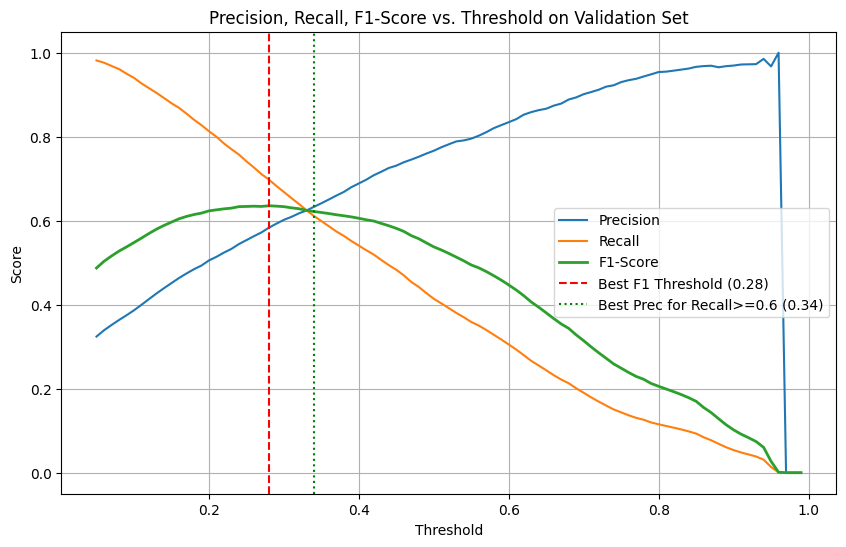


Using final threshold: 0.3


In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve
import numpy as np
import matplotlib.pyplot as plt

# 假设 y_val 和 y_pred_proba_val 已经准备好

thresholds = np.arange(0.05, 1.0, 0.01) # 候选阈值范围
precisions = []
recalls = []
f1_scores = []

for thresh in thresholds:
    # 将概率按当前阈值转换为 0/1 预测
    y_pred_binary_val = (y_pred_proba_val >= thresh).astype(int)

    # 计算指标 (注意 zero_division=0 避免除以零警告)
    precisions.append(precision_score(y_val, y_pred_binary_val, zero_division=0))
    recalls.append(recall_score(y_val, y_pred_binary_val, zero_division=0))
    f1_scores.append(f1_score(y_val, y_pred_binary_val, zero_division=0))

# 找到最佳阈值
# 例如，找到使 F1 分数最高的阈值
best_f1_idx = np.argmax(f1_scores)
best_threshold_f1 = thresholds[best_f1_idx]
print(f"Best threshold for F1-score: {best_threshold_f1:.4f} (F1={f1_scores[best_f1_idx]:.4f})")
print(f"Precision at this threshold: {precisions[best_f1_idx]:.4f}")
print(f"Recall at this threshold: {recalls[best_f1_idx]:.4f}")

# 或者，你可能有一个最低 Recall 要求，然后在此基础上最大化 Precision
min_recall_target = 0.6 # 示例：至少要找到 60% 的真实关注
valid_threshold_indices = [i for i, r in enumerate(recalls) if r >= min_recall_target]
if valid_threshold_indices:
     best_precision_idx = valid_threshold_indices[np.argmax(np.array(precisions)[valid_threshold_indices])]
     best_threshold_prec_recall = thresholds[best_precision_idx]
     print(f"\nBest threshold for Recall >= {min_recall_target} and max Precision: {best_threshold_prec_recall:.4f}")
     print(f"Precision: {precisions[best_precision_idx]:.4f}, Recall: {recalls[best_precision_idx]:.4f}")
else:
     print(f"\nCould not find a threshold meeting the minimum Recall requirement of {min_recall_target}")


# 可视化指标随阈值变化 (可选但推荐)
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1_scores, label='F1-Score', linewidth=2)
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall, F1-Score vs. Threshold on Validation Set")
plt.axvline(best_threshold_f1, color='red', linestyle='--', label=f'Best F1 Threshold ({best_threshold_f1:.2f})')
# 如果用了第二种方法，也可以画出那条线
if valid_threshold_indices:
    plt.axvline(best_threshold_prec_recall, color='green', linestyle=':', label=f'Best Prec for Recall>={min_recall_target} ({best_threshold_prec_recall:.2f})')
plt.legend()
plt.grid(True)
plt.show()

# --- 使用你选择的最佳阈值 ---
# final_prediction_threshold = best_threshold_f1 # 或者 best_threshold_prec_recall
final_prediction_threshold = 0.3 # 或者根据上面的分析选择一个值
print(f"\nUsing final threshold: {final_prediction_threshold}")


In [20]:

# --- 5. 准备最终预测数据 (针对指定用户和 2024-07-22) ---
print("\n--- Preparing Final Prediction Data ---")
target_users = ['U7', 'U6749', 'U5769', 'U14990', 'U52010']

# 筛选附件2中目标用户的互动记录 (预测当天的互动)
predict_day_interactions = df_future_interactions[
    (df_future_interactions['Date'] == predict_interaction_date) &
    (df_future_interactions['UserID'].isin(target_users))
].copy()



# 获取这些用户在当天互动的 (UserID, BloggerID) 候选对
prediction_candidates = predict_day_interactions[[
    'UserID', 'BloggerID']].drop_duplicates()



# 找出目标用户在预测日期 *之前* 已经关注的博主 (使用附件1全部历史数据直到 predict_hist_end_date)
all_hist_follows = df_hist[(df_hist['Date'] <= predict_hist_end_date) & (
    df_hist['UserBehaviour'] == 4)][['UserID', 'BloggerID']].drop_duplicates()
target_user_hist_follows = all_hist_follows[all_hist_follows['UserID'].isin(
    target_users)].copy()
target_user_hist_follows['already_followed'] = 1


# 从候选对中移除已经关注的
predict_targets = pd.merge(prediction_candidates, target_user_hist_follows, on=[
                           'UserID', 'BloggerID'], how='left')

predict_targets = predict_targets[predict_targets['already_followed'].isna()]
predict_targets = predict_targets[['UserID', 'BloggerID']]

print(f"Found {len(predict_targets)} potential new follow pairs for target users on {predict_interaction_date.date()}.")



--- Preparing Final Prediction Data ---
Found 42 potential new follow pairs for target users on 2024-07-22.


In [21]:

if not predict_targets.empty:
    # 为预测集创建特征
    # 历史数据使用附件1 (截止到 predict_hist_end_date)
    # 当天互动数据使用 predict_day_interactions (来自 predict_interaction_date)
    predict_features = create_features(predict_targets[['UserID', 'BloggerID']],
                                       df_hist,  # 全部历史数据直到 predict_hist_end_date
                                       predict_day_interactions,  # 7.22 的互动数据
                                       predict_hist_end_date)  # 历史数据截止日期为 7.20

    # 确保预测数据的列与训练数据一致且顺序相同
    # 使用训练时确定的 common_features
    predict_features = predict_features[common_features]

    # --- 6. 进行最终预测 ---
    print("\n--- Making Final Predictions ---")

    # 使用训练好的模型进行预测
    # 如果使用了早停，模型默认使用最佳迭代次数进行预测
    predictions_proba = model.predict_proba(predict_features)[:, 1]

    # 将概率添加到预测目标DataFrame中
    predict_targets['follow_probability'] = predictions_proba

    # 选择概率大于阈值的作为预测结果
    prediction_threshold = 0.28  # 可以根据验证集上的指标调整此阈值
    predicted_follows = predict_targets[predict_targets['follow_probability']
                                        > prediction_threshold]

    print(
        f"Predicted {len(predicted_follows)} new follows with threshold > {prediction_threshold}.")

else:
    print("No potential new follow pairs found for target users to predict.")
    predicted_follows = pd.DataFrame(
        columns=['UserID', 'BloggerID', 'follow_probability'])  # 创建空的DataFrame

Creating features based on data up to 2024-07-20 using interactions from 2024-07-22...


/var/folders/f_/c214vm4j6sb183tqrqmgczwc0000gn/T/ipykernel_95290/3274639005.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  user_agg = hist_ref.groupby('UserID').agg(
/var/folders/f_/c214vm4j6sb183tqrqmgczwc0000gn/T/ipykernel_95290/3274639005.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  blogger_agg = hist_ref.groupby('BloggerID').agg(
/var/folders/f_/c214vm4j6sb183tqrqmgczwc0000gn/T/ipykernel_95290/3274639005.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True t

Feature creation finished for reference date 2024-07-20. Final columns: 34

--- Making Final Predictions ---
Predicted 5 new follows with threshold > 0.28.


In [23]:

# --- 7. 输出结果 ---
print("\n--- Generating Final Results for Table 2 ---")
# 按用户分组，收集预测关注的博主ID
if not predicted_follows.empty:
    final_results = predicted_follows.groupby(
        'UserID')['BloggerID'].apply(list).reset_index()
else:
    final_results = pd.DataFrame(columns=['UserID', 'BloggerID'])  # 空结果

# 创建结果表
table2_data = {'UserID': target_users}
table2_df = pd.DataFrame(table2_data)

# 合并预测结果
table2_df = pd.merge(table2_df, final_results, on='UserID', how='left')

# 格式化输出
table2_df.rename(columns={'BloggerID': '新关注博主ID'}, inplace=True)
table2_df['新关注博主ID'] = table2_df['新关注博主ID'].apply(
    lambda x: x if isinstance(x, list) else [])

print("\n--- 问题2 预测结果 ---")
# 为了更清晰地展示列表内容，可以调整pandas显示选项或自定义打印
# print(table2_df.to_string(index=False))
for index, row in table2_df.iterrows():
    user_id = row['UserID']
    blogger_ids = row['新关注博主ID']
    # 将Category类型的BloggerID转换为字符串，以便打印
    blogger_id_strs = [str(bid) for bid in blogger_ids]
    print(
        f"用户ID: {user_id}, 新关注博主ID: {blogger_id_strs if blogger_id_strs else '无'}")


# 可以将结果保存到文件
# table2_df['新关注博主ID_str'] = table2_df['新关注博主ID'].apply(lambda x: ','.join(map(str, x)) if x else '')
# table2_df[['UserID', '新关注博主ID_str']].to_csv('problem2_predictions_validated.csv', index=False, encoding='utf-8-sig')

print("\nDone.")



--- Generating Final Results for Table 2 ---

--- 问题2 预测结果 ---
用户ID: U7, 新关注博主ID: ['B7', 'B27']
用户ID: U6749, 新关注博主ID: ['B17']
用户ID: U5769, 新关注博主ID: 无
用户ID: U14990, 新关注博主ID: ['B24']
用户ID: U52010, 新关注博主ID: ['B13']

Done.
